In [42]:
from datautils import get_dls
from src.models.resnet import ResNet
from src.learner import  transfer_weights
import torch.nn as nn
from src.basics import set_device
import torch
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
#set_device()

class params:
    def __init__(self, **kwargs):
        for key in kwargs:
            setattr(self, key, kwargs[key])

In [6]:
#dls = get_dls(params(batch_size=1, dset='ettm1', num_workers=1, classification=0.05, context_points=366, target_points=2, features='M')) 
dls = get_dls(params(batch_size=1, dset='computers', num_workers=1, context_points=720)) 


In [7]:
dl_train = iter(dls.train)


In [8]:
c=0
s=0
for x,y in dl_train:
    s+=y
    c+=1

In [9]:
print(s/c)

tensor([[0.5000]])


In [10]:
model = ResNet(1, 'classification', 2, .2)

In [11]:
w_path = 'saved_models/gunpoint/resnet/based_model/resnet_cw150_epochs-pretrain20_model1.pth'
w_path_rsnt_comp = 'saved_models/computers/resnet/based_model/resnet_cw720_epochs-pretrain50_model1.pth'
model = transfer_weights(weights_path=w_path_rsnt_comp, model=model, exclude_head=False, device='cuda')

weights from saved_models/computers/resnet/based_model/resnet_cw720_epochs-pretrain50_model1.pth successfully transferred!



In [12]:
model.eval()

ResNet(
  (block1): ResNetBlock(
    (conv1): Conv1d(1, 64, kernel_size=(8,), stride=(1,), padding=same, bias=False)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=same, bias=False)
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same, bias=False)
    (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv1d(1, 64, kernel_size=(1,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (block2): ResNetBlock(
    (conv1): Conv1d(64, 128, kernel_size=(8,), stride=(1,), padding=same, bias=False)
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(128, 1

In [13]:
class ResNetCam(nn.Module):
    def __init__(self, base_model):
        super(ResNetCam, self).__init__()
        self.model = model
        self.before_gap = nn.Sequential(model.block1, model.block2, model.block3)

    def forward(self, x):

        return self.before_gap(x.permute(0, 2, 1)).permute(0, 2, 1), self.model(x)

In [15]:
resnet_cam = ResNetCam(model)

In [18]:
class_weights = list(model.head.parameters())

In [19]:
class_weights[0].shape

torch.Size([2, 128])

In [20]:
def create_cam(x, resnet_cam: ResNetCam, class_weights):
    before_gap_out, pred = resnet_cam(x)
    predicted_class = pred.argmax(axis=1)
    print("predicted", predicted_class)
    dominate_class_weight = [el[predicted_class] for el in class_weights]



    cam = torch.matmul(before_gap_out, dominate_class_weight[0].reshape(-1, 1)) +  dominate_class_weight[1]

    return cam


In [21]:
dl = iter(dls.train)

In [22]:
X= X.unsqueeze(-1)

NameError: name 'X' is not defined

In [23]:
cam = create_cam(resnet_cam=resnet_cam, class_weights=class_weights, x=X.cuda())

NameError: name 'X' is not defined

In [55]:
def plot_cam(resnet_cam,class_weights, X, Y):
    X = X.unsqueeze(-1)    
    n = X.shape[1]

    cam = create_cam(resnet_cam=resnet_cam, class_weights=class_weights, x=X.cuda()).reshape((n,1)).cpu().detach().numpy()
    cam = (cam - np.min(cam))*100/np.max(cam)
    x = np.linspace(0, n-1, n)
    X = X.cpu().detach().numpy()
    X = X.reshape((n, 1))
    f = interp1d(range(n), X[:,0])
    y = f(x)
    f = interp1d(range(n), cam[:,0])
    cam_ = f(x).astype(int)
    print(f"True class : {Y.data}")
    plt.scatter(x=x, y=y, c=cam_, s=2, vmin=np.min(cam_), vmax=np.max(cam_), linewidths=1, cmap='seismic')
    plt.colorbar()
    plt.show()


predicted tensor([[0]], device='cuda:0')
True class : tensor([[0]])


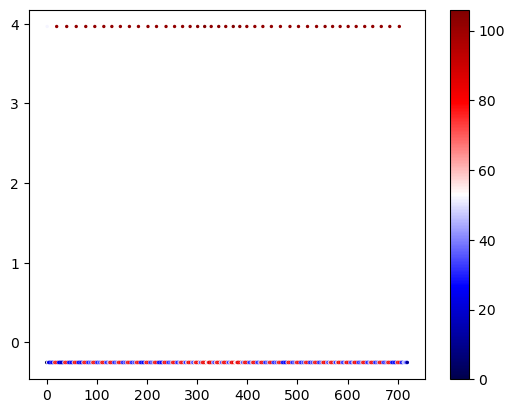

In [59]:
X, Y = next(dl)
plot_cam(resnet_cam, class_weights, X, Y)

In [181]:
cam = cam.reshape((150,1)).cpu().detach().numpy()

In [182]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d


In [183]:
cam = (cam - np.min(cam))*100/np.max(cam)

In [184]:
x = np.linspace(0, 149, 2000)

In [185]:
len(x)

2000

In [186]:
X = X.cpu().detach().numpy()

In [187]:
X = X.reshape((150, 1))

In [188]:
f = interp1d(range(150), X[:,0])

In [189]:
y = f(x)

In [190]:
f = interp1d(range(150), cam[:,0])

In [191]:
cam_ = f(x).astype(int)

In [192]:
len(x)

2000

In [193]:
cam_

array([8, 8, 8, ..., 7, 7, 7])

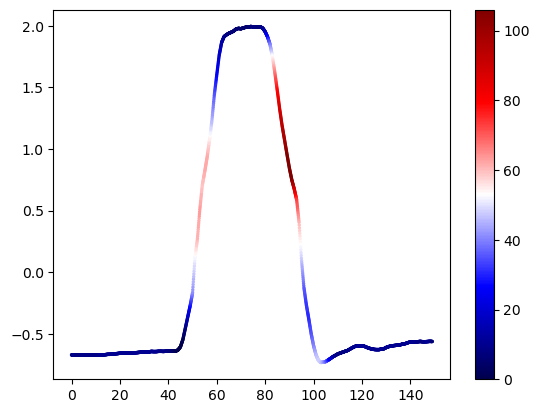

In [194]:
plt.scatter(x=x, y=y, c=cam_, s=2, vmin=0, vmax=106, linewidths=1, cmap='seismic')
plt.colorbar()
plt.show()

array([-0.70239067, -0.70084679, -0.69996232, -0.69718081, -0.69458634,
       -0.69244242, -0.69285542, -0.69186938, -0.69059932, -0.69200331,
       -0.6895448 , -0.68937188, -0.68825352, -0.68804711, -0.68884331,
       -0.69069564, -0.69032753, -0.69069666, -0.68958259, -0.69152522,
       -0.69018674, -0.69187611, -0.69278497, -0.6922068 , -0.69021207,
       -0.68952394, -0.6905576 , -0.68939519, -0.69047791, -0.6890102 ,
       -0.68788266, -0.68823051, -0.68623233, -0.68733907, -0.68813682,
       -0.68880016, -0.68905377, -0.68917179, -0.68835026, -0.68951595,
       -0.68751478, -0.68694514, -0.68758315, -0.68934029, -0.67899925,
       -0.63702548, -0.56236959, -0.45081741, -0.30608577, -0.11732343,
        0.07660882,  0.26131174,  0.43502915,  0.58489186,  0.73178726,
        0.8966794 ,  1.07062376,  1.23967111,  1.37652218,  1.48971772,
        1.53818083,  1.54858506,  1.55058479,  1.55567145,  1.56205356,
        1.56076527,  1.56956124,  1.57625401,  1.58528244,  1.59